In [1]:
import dame_flame
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import heapq
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LinearRegression
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF

C:\Users\Neha\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
STAR_Students = pd.read_spss('STAR_Students.sav')

In [3]:
#STAR_Students['gksurban'].value_counts()
# d = {"RURAL": 0, "URBAN":1, "SUBURBAN": 2, "INNER CITY": 3}
    
df_trunc = STAR_Students.loc[:, STAR_Students.columns.intersection(
    ['gkclasstype', 'gender', 'race', 'gkfreelunch', 'gkschid', 'gktmathss', 'gktreadss', 'g1freelunch', 'g2freelunch', 'g3freelunch',
    'gktgen', 'gktrace', 'gkthighdegree', 'birthmonth', 'birthyear', 'gksurban'])]


d = {"WHITE": 1, "BLACK": 0, "ASIAN": 1, "HISPANIC": 0, "OTHER": 0, 
     "NATIVE AMERICAN": 0}
df_trunc['race'] = df_trunc['race'].map(d)

d = {"NON-FREE LUNCH": 0, "FREE LUNCH": 1}
df_trunc['gkfreelunch'] = df_trunc['gkfreelunch'].map(d)
df_trunc['g1freelunch'] = df_trunc['g1freelunch'].map(d)
df_trunc['g2freelunch'] = df_trunc['g2freelunch'].map(d)
df_trunc['g3freelunch'] = df_trunc['g3freelunch'].map(d)

d = {"BACHELORS": 0, "MASTERS": 1, "MASTERS + ": 1, "SPECIALIST": 1}
df_trunc['gkthighdegree'] = df_trunc['gkthighdegree'].map(d)

d = {"MALE": 1, "FEMALE": 0}
df_trunc['gender'] = df_trunc['gender'].map(d)
df_trunc['gktgen'] = df_trunc['gktgen'].map(d)

d = {"WHITE": 1, "BLACK": 0}
df_trunc['gktrace'] = df_trunc['gktrace'].map(d)

d = {"JANUARY": 0, "FEBRUARY": 1, "MARCH": 2, "APRIL": 3, "MAY": 4, 
     "JUNE": 5, "JULY": 6, "AUGUST": 7, "SEPTEMBER": 8, "OCTOBER": 9, 
     "NOVEMBER": 10, "DECEMBER": 11}
df_trunc['birthmonth'] = df_trunc['birthmonth'].map(d)

d = {1977: 0, 1978: 1, 1979: 2, 1980:3, 1981:4}
df_trunc['birthyear'] = df_trunc['birthyear'].map(d)

d = {"RURAL": 0, "URBAN":1, "SUBURBAN": 2, "INNER CITY": 3}
df_trunc['gksurban'] = df_trunc['gksurban'].map(d)

d = {"SMALL CLASS": int(1), "REGULAR CLASS": int(0), 
     "REGULAR + AIDE CLASS": int(0)}
df_trunc['ksmall'] = df_trunc['gkclasstype'].map(d)

# df_trunc = df_trunc.dropna().copy()

# Create age variable counting months
df_trunc['age'] = df_trunc['birthyear']*12 + df_trunc['birthmonth']
# Bin age into deciles
df_trunc['age'] = pd.qcut(df_trunc['age'], q=10, labels=False)
df_trunc = df_trunc.drop(columns=['gkclasstype', 'birthmonth', 'birthyear'])
df_trunc = df_trunc.rename(columns={"ksmall": "treated"}) ## NOTE TO SELF -- COME BACK TO WE SHOULDNT HAVE TO DO THIS

In [4]:
for i in df_trunc.index:
    if df_trunc.loc[i, 'g1freelunch'] == 1 or df_trunc.loc[i, 'g2freelunch'] == 1 or df_trunc.loc[i, 'g3freelunch'] == 1 or df_trunc.loc[i, 'gkfreelunch'] == 1:
        df_trunc.loc[i, 'gkfreelunch'] = 1
    else:
        df_trunc.loc[i, 'gkfreelunch'] = 0
df_trunc = df_trunc.drop(columns=['g1freelunch', 'g2freelunch', 'g3freelunch'])

# df_trunc=df_trunc.dropna(subset=['treated'])
df_trunc = df_trunc.dropna() # COME BACK TO!

In [5]:
ecdf_reading = ECDF(df_trunc[df_trunc['treated'] == 0]['gktreadss'])
ecdf_math = ECDF(df_trunc[df_trunc['treated'] == 0]['gktmathss'])
df_trunc['read_outcome'] = ecdf_reading(df_trunc['gktreadss'])*100
df_trunc['math_outcome'] = ecdf_math(df_trunc['gktmathss'])*100
df_trunc['outcome'] = (df_trunc['read_outcome'] + df_trunc['math_outcome'])/2

In [6]:
'''
math_array = df_trunc[df_trunc['treated'] == 0]['gktmathss']
reading_array = df_trunc[df_trunc['treated'] == 0]['gktreadss']
#df_trunc['read_outcome'] = stats.percentileofscore(reading_array, df_trunc['gktreadss'])
#df_trunc['math_outcome'] = stats.percentileofscore(math_array, df_trunc['gktmathss'])
for i in df_trunc.index:
    df_trunc.loc[i, 'math_outcome'] = stats.percentileofscore(a=math_array, score=df_trunc.loc[i,'gktmathss'])
    df_trunc.loc[i, 'read_outcome'] = stats.percentileofscore(a=reading_array, score=df_trunc.loc[i,'gktreadss'])


df_trunc['outcome'] = (df_trunc['read_outcome'] + df_trunc['math_outcome'])/2
'''

'''
df_trunc_untreated = df_trunc[df_trunc['treated'] == 0]
df_trunc_treated = df_trunc[df_trunc['treated'] == 1]
for i in df_trunc_treated.index:
    df_trunc_treated.loc[i, 'gktreadss'] = stats.percentileofscore(df_trunc_untreated['gktreadss'], df_trunc_treated.loc[i,'gktreadss'])
    df_trunc_treated.loc[i, 'gktmathss'] = stats.percentileofscore(df_trunc_untreated['gktmathss'], df_trunc_treated.loc[i,'gktmathss'])

# Percentile the math and reading and then average them
# but do different percentiles for the small class size people and the large people.
df_trunc_untreated = df_trunc[df_trunc['treated'] == 0]
df_trunc_untreated['gktreadss'] = df_trunc_untreated['gktreadss'].rank(pct=True)*100
df_trunc_untreated['gktmathss'] = df_trunc_untreated['gktmathss'].rank(pct=True)*100
df_trunc_untreated['outcome'] = df_trunc_untreated[['gktreadss', 'gktmathss']].mean(axis=1)

#df_trunc_treated = df_trunc[df_trunc['treated'] == 1]
#df_trunc_treated['gktreadss'] = df_trunc_treated['gktreadss'].rank(pct=True)*100
#df_trunc_treated['gktmathss'] = df_trunc_treated['gktmathss'].rank(pct=True)*100
df_trunc_treated['outcome'] = df_trunc_treated[['gktreadss', 'gktmathss']].mean(axis=1)

df = pd.concat([df_trunc_treated, df_trunc_untreated])
df = df.drop(columns=['gktreadss', 'gktmathss'])

df = df.dropna()
'''

"\ndf_trunc_untreated = df_trunc[df_trunc['treated'] == 0]\ndf_trunc_treated = df_trunc[df_trunc['treated'] == 1]\nfor i in df_trunc_treated.index:\n    df_trunc_treated.loc[i, 'gktreadss'] = stats.percentileofscore(df_trunc_untreated['gktreadss'], df_trunc_treated.loc[i,'gktreadss'])\n    df_trunc_treated.loc[i, 'gktmathss'] = stats.percentileofscore(df_trunc_untreated['gktmathss'], df_trunc_treated.loc[i,'gktmathss'])\n\n# Percentile the math and reading and then average them\n# but do different percentiles for the small class size people and the large people.\ndf_trunc_untreated = df_trunc[df_trunc['treated'] == 0]\ndf_trunc_untreated['gktreadss'] = df_trunc_untreated['gktreadss'].rank(pct=True)*100\ndf_trunc_untreated['gktmathss'] = df_trunc_untreated['gktmathss'].rank(pct=True)*100\ndf_trunc_untreated['outcome'] = df_trunc_untreated[['gktreadss', 'gktmathss']].mean(axis=1)\n\n#df_trunc_treated = df_trunc[df_trunc['treated'] == 1]\n#df_trunc_treated['gktreadss'] = df_trunc_treated[

In [7]:
md = sm.OLS(df_trunc['outcome'], sm.add_constant(df_trunc['treated']))
md.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                outcome   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     34.20
Date:                Sat, 18 Feb 2023   Prob (F-statistic):           5.27e-09
Time:                        15:16:19   Log-Likelihood:                -24143.
No. Observations:                5120   AIC:                         4.829e+04
Df Residuals:                    5118   BIC:                         4.830e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         51.3462      0.452    113.722      0.000      50.461      52.231
treated        4.8178      0.824      5.848      0.000       3.203       6.433
==============================================================================
Omnibus:                     1977.007   Durbin-Watson:                   1.790
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              264.793
Skew:                          -0.111   Prob(JB):                     3.17e-58
Kurtosis:                       1.908   Cond. No.                         2.42
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
md = smf.mixedlm(formula="outcome ~ treated", data=df_trunc , groups=df_trunc['gkschid'])
md.fit().summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:            MixedLM Dependent Variable: outcome    
No. Observations: 5120    Method:             REML       
No. Groups:       79      Scale:              558.7809   
Min. group size:  30      Likelihood:         -23574.6243
Max. group size:  123     Converged:          Yes        
Mean group size:  64.8                                   
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      51.109    1.536 33.284 0.000 48.099 54.119
treated         5.572    0.736  7.572 0.000  4.130  7.014
Group Var     173.039    1.245                           
=========================================================

"""

In [9]:
md = smf.mixedlm(formula="outcome ~ gender+race+gkfreelunch+treated", data=df_trunc, groups=df_trunc['gkschid'])
md.fit().summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:             MixedLM  Dependent Variable:  outcome    
No. Observations:  5120     Method:              REML       
No. Groups:        79       Scale:               517.1212   
Min. group size:   30       Likelihood:          -23369.5767
Max. group size:   123      Converged:           Yes        
Mean group size:   64.8                                     
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept         41.559    1.708 24.335 0.000 38.212 44.906
gender[T.1]       -4.763    0.640 -7.440 0.000 -6.018 -3.508
gkfreelunch[T.0]  12.274    0.771 15.928 0.000 10.764 13.785
race               9.296    1.277  7.278 0.000  6.793 11.800
treated            5.579    0.708  7.881 0.000  4.191  6.966
Group Var        147.623    1.111                           
============================================================

"""

In [10]:
fes = pd.get_dummies(df_trunc['gkschid'])
fes = fes.drop(columns=[161183.0])
y = df_trunc.loc[:,['outcome']]
x = df_trunc.loc[:, ['gender', 'race', 'gkfreelunch', 'treated']]
x = pd.concat([fes,x],axis=1)
x = sm.add_constant(x)
model = sm.OLS(y,x)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                outcome   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     27.30
Date:                Sat, 18 Feb 2023   Prob (F-statistic):               0.00
Time:                        15:16:21   Log-Likelihood:                -23219.
No. Observations:                5120   AIC:                         4.660e+04
Df Residuals:                    5037   BIC:                         4.715e+04
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          60.7510      2.771     21.927      0.000      55.319      66.183
112038.0      -30.2353      4.043     -7.478      0.000     -38.162     -22.308
123056.0      -17.4150      4.103     -4.244      0.000     -25.459      -9.371
128068.0      -18.5177      3.934     -4.707      0.000     -26.231     -10.805
128076.0      -24.7735      3.875     -6.393      0.000     -32.370     -17.177
128079.0      -26.3821      3.865     -6.825      0.000     -33.960     -18.804
130085.0      -18.0859      3.666     -4.933      0.000     -25.274     -10.898
159171.0        9.8644      3.326      2.966      0.003       3.343      16.385
161176.0      -16.6120      3.531     -4.704      0.000     -23.535      -9.689
162184.0      -13.7527      3.888     -3.537      0.000     -21.375      -6.130
164198.0      -10.1512      4.018     -2.526      0.012     -18.028      -2.274
165199.0        2.6009      4.407      0.590      0.555      -6.039      11.241
166203.0      -18.5101      4.285     -4.320      0.000     -26.911     -10.109
168211.0      -10.0551      3.390     -2.966      0.003     -16.701      -3.409
168214.0        2.5600      3.969      0.645      0.519      -5.220      10.340
169219.0        2.9215      4.157      0.703      0.482      -5.227      11.070
169229.0       -2.6218      3.420     -0.767      0.443      -9.327       4.083
169231.0      -27.8323      3.994     -6.969      0.000     -35.662     -20.003
169280.0       -3.5777      4.059     -0.882      0.378     -11.534       4.379
170295.0       -3.0820      3.719     -0.829      0.407     -10.372       4.208
173312.0       13.3713      3.893      3.435      0.001       5.740      21.003
176329.0        5.5987      3.739      1.497      0.134      -1.731      12.929
180344.0       -6.5009      3.426     -1.897      0.058     -13.218       0.216
189378.0      -22.4983      3.657     -6.153      0.000     -29.667     -15.330
189382.0      -11.2480      3.838     -2.931      0.003     -18.772      -3.724
189396.0      -21.6991      3.839     -5.652      0.000     -29.225     -14.173
191411.0       -2.9399      4.489     -0.655      0.513     -11.740       5.860
193422.0        2.0550      3.800      0.541      0.589      -5.395       9.504
193423.0       -4.1142      3.584     -1.148      0.251     -11.140       2.912
201449.0        4.5665      3.465      1.318      0.188      -2.226      11.359
203452.0      -13.7293      3.450     -3.980      0.000     -20.493      -6.966
203457.0        5.4469      4.314      1.263      0.207      -3.010      13.903
205488.0      -12.6341      4.053     -3.117      0.002     -20.581      -4.688
205489.0      -10.6671      4.039     -2.641      0.008     -18.585      -2.749
205490.0      -29.0381      4.010     -7.241      0.000     -36.899     -21.177
205491.0      -15.6385      3.699     -4.22

In [11]:
df_trunc = df_trunc.drop(columns=['math_outcome', 'read_outcome'])

In [12]:
# Do mice
'''
from sklearn.tree import DecisionTreeRegressor

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(max_iter=10, random_state=1,
                       estimator=DecisionTreeRegressor())
imp.fit(df)
tmp_df = pd.DataFrame(data=np.round(imp.transform(df)),
                      columns=df.columns,
                      index=df.index)
# convert floats to ints because MICE creates floats
cols = list(df.columns)
cols.remove("outcome")
tmp_df[cols] = tmp_df[cols].astype('int64')
'''

'\nfrom sklearn.tree import DecisionTreeRegressor\n\nfrom sklearn.experimental import enable_iterative_imputer\nfrom sklearn.impute import IterativeImputer\n\nimp = IterativeImputer(max_iter=10, random_state=1,\n                       estimator=DecisionTreeRegressor())\nimp.fit(df)\ntmp_df = pd.DataFrame(data=np.round(imp.transform(df)),\n                      columns=df.columns,\n                      index=df.index)\n# convert floats to ints because MICE creates floats\ncols = list(df.columns)\ncols.remove("outcome")\ntmp_df[cols] = tmp_df[cols].astype(\'int64\')\n'

In [13]:
df_trunc = df_trunc.drop(columns=['gktreadss', 'gktmathss'])

In [14]:
df_trunc.head()

,gender,race,gkschid,gksurban,gktgen,gktrace,gkthighdegree,gkfreelunch,treated,age,outcome
133,1,0.0,169280.0,2,0,1,0.0,0,0.0,5.0,48.450586
246,0,1.0,218562.0,1,0,1,1.0,1,0.0,9.0,70.212172
263,0,0.0,205492.0,2,0,1,0.0,1,1.0,2.0,85.538805
266,1,1.0,257899.0,0,0,1,1.0,0,0.0,2.0,79.299274
275,1,1.0,161176.0,0,0,1,0.0,1,0.0,2.0,32.398102


In [15]:
# Do the matching

models = []
random_seeds = [1111, 2222, 3333, 4444]
for i in range(4):
    matching_df, holdout_df = train_test_split(df_trunc, test_size=0.2, random_state=random_seeds[i])
    model_dame = dame_flame.matching.DAME(
        repeats=False, verbose=0, adaptive_weights='decisiontree')
    model_dame.fit(holdout_data=holdout_df)
    model_dame.predict(matching_df)
    models.append(model_dame)



2975 units matched. We finished with no more treated units to match
3007 units matched. We finished with no more treated units to match
2943 units matched. We finished with no more treated units to match
2999 units matched. We finished with no more treated units to match


In [16]:
for i in range(len(models)):
    ate, var = dame_flame.utils.post_processing.var_ATE(matching_object=models[i])
    print("ATE of trial", i, ":", ate,". Variance: ", var)

ATE of trial 0 : 0.8991877492386828 . Variance:  5.107351792382683
ATE of trial 1 : 0.9123505507663184 . Variance:  4.889610017616739
ATE of trial 2 : 0.8806818133158267 . Variance:  5.057902885406864
ATE of trial 3 : 0.8998682484477298 . Variance:  5.435432162854705


In [17]:
# compute stuff for plot
# Create the plot
match_dfs = []
for i in models:
    match_dfs.append(i.input_data)

for i in range(4):
    colname = 'cates'
    match_dfs[i][colname] = dame_flame.utils.post_processing.CATE(
        models[i], match_dfs[i].index)

dame_len_groups = []
dame_cate_of_groups = []

for i in range(4):

    model_dame = models[i]
    groups = list(range(len(model_dame.units_per_group)))

    dame_cate_of_group = []
    dame_len_group = []
    dame_len_treated = []
    maxcate = 0.0
    maxgroupnum = 0
    index = 0

    flame_cate_of_group = []
    flame_len_group = []
    large_groups = []
    for group in model_dame.units_per_group:
        dame_cate_of_group.append(dame_flame.utils.post_processing.CATE(
            model_dame, group[0]))
        dame_len_group.append(len(group))

        # find len of just treated units
        df_mmg = df_trunc.loc[group]
        treated = df_mmg.loc[df_mmg["treated"] == 1]

    dame_len_groups.append(dame_len_group)
    dame_cate_of_groups.append(dame_cate_of_group)


C:\Users\Neha\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Neha\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Neha\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

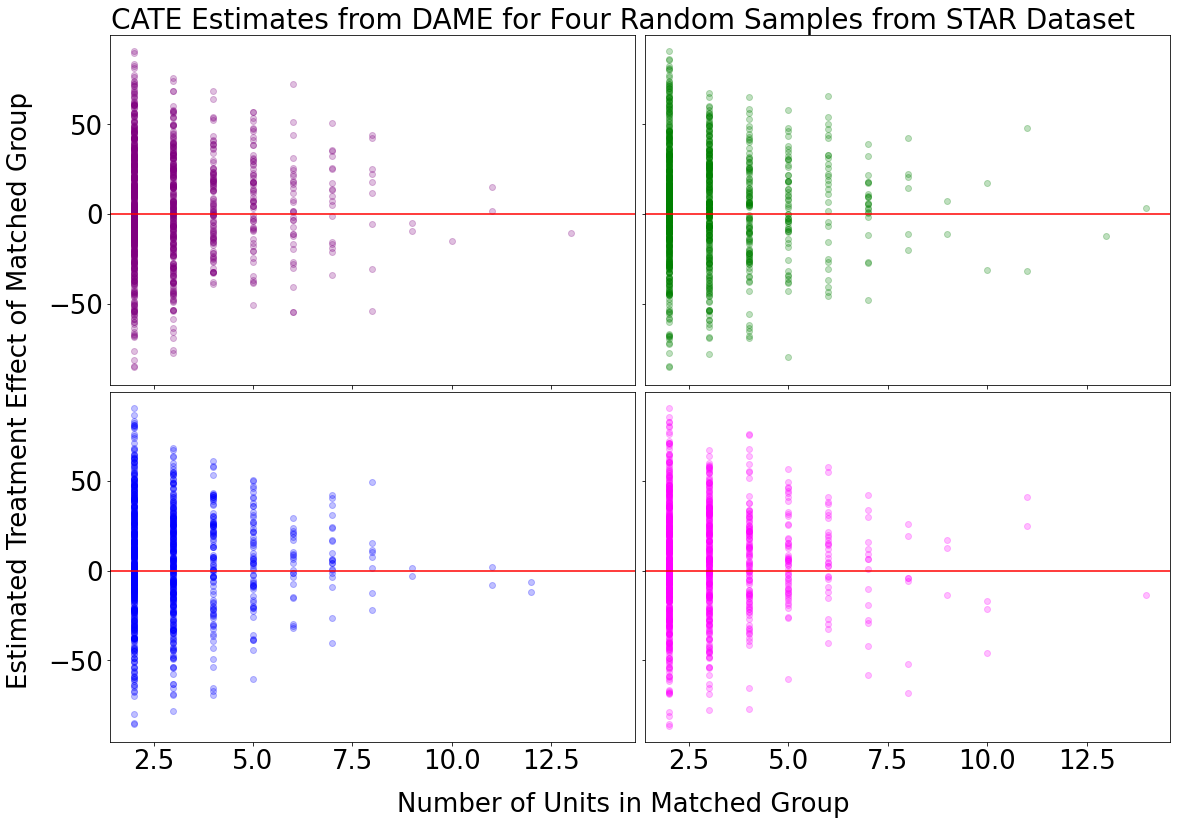

In [18]:


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (19,13), 
                                             sharex=True, sharey=True)
fig.text(0.5, 0.05, 'Number of Units in Matched Group', ha='center', 
         fontsize=26)
fig.text(0.05, 0.5, 'Estimated Treatment Effect of Matched Group', 
         va='center', rotation='vertical', fontsize=26)
fig.suptitle("CATE Estimates from DAME for Four Random Samples from STAR Dataset", fontsize=28, y=0.91)
ax1.axhline(y=0.0, color='r', linestyle='-')
ax2.axhline(y=0.0, color='r', linestyle='-')
ax3.axhline(y=0.0, color='r', linestyle='-')
ax4.axhline(y=0.0, color='r', linestyle='-')

ax1.tick_params(labelsize=26)
ax2.tick_params(labelsize=26)
ax3.tick_params(labelsize=26)
ax4.tick_params(labelsize=26)

ax1.scatter(dame_len_groups[0], dame_cate_of_groups[0], color="purple", 
            alpha = 0.25)
#ax1.text(0.15, 0.9,'ATE: '+str(round(ates[0],2)), ha='center', va='center',
#         transform=ax1.transAxes, fontsize=26)

ax2.scatter(dame_len_groups[1], dame_cate_of_groups[1], color="green", 
            alpha = 0.25)
#ax2.text(0.15, 0.9,'ATE: '+str(round(ates[1],2)), ha='center', va='center',
#         transform=ax2.transAxes, fontsize=26)

ax3.scatter(dame_len_groups[2], dame_cate_of_groups[2], color="blue", 
            alpha = 0.25)
#ax3.text(0.15, 0.9,'ATE: '+str(round(ates[2],2)), ha='center', va='center',
#         transform=ax3.transAxes, fontsize=26)

ax4.scatter(dame_len_groups[3], dame_cate_of_groups[3], color="magenta",
            alpha = 0.25)
#ax4.text(0.15, 0.9,'ATE: '+str(round(ates[3],2)), ha='center', va='center',
#         transform=ax4.transAxes, fontsize=26)

plt.subplots_adjust(wspace=.02, hspace=.02)
## plt.savefig('cate-graph4.png', dpi = 200)

In [19]:
list_star_covars = []
for modelid in range(len(models)):

    # Pull out the groups with 10 or more units in the matched group
    model = models[modelid]
    large_groups = []
    for group in model.units_per_group:
        if len(group) >= 8:
            large_groups.append(group)

    covariates = set(models[modelid].input_data.columns) - set(['outcome', 'treated', 'cates'])
    # Which covars did the large group match on?
    star_covars = dict()
    for group in large_groups:
        group_star_covars = []
        matched_df = models[modelid].df_units_and_covars_matched.loc[group]
        for covar in covariates:
            if '*' in matched_df[covar].values:
                group_star_covars.append(covar)
        cate_of_group = models[modelid].input_data.loc[group[0], 'cates']
        star_covars[cate_of_group] = group_star_covars
        
    list_star_covars.append(star_covars)

In [20]:
list_star_covars

[{17.687976921645266: [],
  11.59368269921032: [],
  43.830262423227246: [],
  25.048855388051365: [],
  -15.112600037223153: ['gktrace'],
  -5.161721304937387: ['gktrace'],
  -30.61737257717158: ['gktrace'],
  42.161202839594814: ['gkthighdegree', 'gktrace'],
  1.6024567280848743: ['age'],
  -54.02408869745554: ['age'],
  -5.407992342665715: ['age'],
  -10.908710217755463: ['age'],
  22.00818909361623: ['age'],
  -9.81295365717476: ['gkthighdegree', 'age'],
  15.111049072523112: ['gkthighdegree', 'gktrace', 'age']},
 {47.829424902289226: [],
  20.48536332455931: [],
  22.461846268378935: [],
  -11.438143096434565: ['gktrace'],
  42.161202839594814: ['gkthighdegree', 'gktrace'],
  -11.081199649038837: ['age'],
  -12.38949376512192: ['age'],
  14.563558533407779: ['age'],
  16.99236925367579: ['age'],
  -32.00586264656615: ['age'],
  -20.2560421153386: ['gkthighdegree', 'age'],
  -31.24573484707488: ['gkthighdegree', 'age'],
  7.0049320677461395: ['gkthighdegree', 'gktrace', 'age'],
  3

In [21]:
modelid = 2
ids = np.where((models[modelid].input_data['race']==0) & (models[modelid].input_data['gender']==1) & (models[modelid].input_data['age']==0))
dame_flame.utils.post_processing.MG(models[modelid], list(ids[0]))

Unit 394 does not have any matches
Unit 633 does not have any matches
Unit 841 does not have any matches
Unit 1710 does not have any matches
Unit 2025 does not have any matches
Unit 2354 does not have any matches
Unit 3293 does not have any matches
Unit 3394 does not have any matches


[nan,
 nan,
 nan,
 nan,
       gender  race   gkschid gksurban gktgen gktrace gkthighdegree  \
 1934       *   1.0  169219.0        2      0       1             *   
 10118      *   1.0  169219.0        2      0       1             *   
 
       gkfreelunch  treated  age    outcome     cates  
 1934            *      1.0  2.0  88.428252  6.867672  
 10118           *      0.0  2.0  81.560581  6.867672  ,
 nan,
      gender  race   gkschid gksurban gktgen gktrace gkthighdegree gkfreelunch  \
 2750      1   1.0  128068.0        0      0       1             *           0   
 3483      1   1.0  128068.0        0      0       1             *           0   
 2147      1   1.0  128068.0        0      0       1             *           0   
 3131      1   1.0  128068.0        0      0       1             *           0   
 287       1   1.0  128068.0        0      0       1             *           0   
 6838      1   1.0  128068.0        0      0       1             *           0   
 2751      1

In [22]:
## Check the matched group with the most units in each trial -- also which covariates did they use and which units in their MMG?

In [23]:
## Run DAME and FLAME and show why we chose DAME for this dataset. What happens if we run FLAME?
flame_models = []
random_seeds = [1111, 2222, 3333, 4444]
for i in range(4):
    matching_df, holdout_df = train_test_split(df_trunc, test_size=0.2, random_state=random_seeds[i])
    model_flame = dame_flame.matching.FLAME(
        repeats=False, verbose=3, adaptive_weights='decisiontree', 
        missing_holdout_replace=1, missing_data_replace=1)
    model_flame.fit(holdout_data=holdout_df)
    result_flame = model_flame.predict(matching_df)
    flame_models.append(model_flame)


Iteration number:  1
	Number of matched groups formed in total:  358
	Unmatched treated units:  783 out of a total of  1227 treated units
	Unmatched control units:  2234 out of a total of  2869 control units
	Predictive error of covariates chosen this iteration:  0
	Number of matches made in this iteration:  1079
	Number of matches made so far:  1079
	In this iteration, the covariates dropped are:  set()
Iteration number:  2
	Number of matched groups formed in total:  358
	Unmatched treated units:  783 out of a total of  1227 treated units
	Unmatched control units:  2234 out of a total of  2869 control units
	Predictive error of covariates chosen this iteration:  63.992100232481256
	Number of matches made in this iteration:  0
	Number of matches made so far:  1079
	In this iteration, the covariates dropped are:  gktgen
Iteration number:  3
	Number of matched groups formed in total:  358
	Unmatched treated units:  783 out of a total of  1227 treated units
	Unmatched control units:  2234

Iteration number:  5
	Number of matched groups formed in total:  448
	Unmatched treated units:  649 out of a total of  1224 treated units
	Unmatched control units:  2118 out of a total of  2872 control units
	Predictive error of covariates chosen this iteration:  100.97588976385877
	Number of matches made in this iteration:  282
	Number of matches made so far:  1329
	In this iteration, the covariates dropped are:  race
Iteration number:  6
	Number of matched groups formed in total:  652
	Unmatched treated units:  397 out of a total of  1224 treated units
	Unmatched control units:  1772 out of a total of  2872 control units
	Predictive error of covariates chosen this iteration:  144.18842694993984
	Number of matches made in this iteration:  880
	Number of matches made so far:  1927
	In this iteration, the covariates dropped are:  gkthighdegree
Iteration number:  7
	Number of matched groups formed in total:  757
	Unmatched treated units:  273 out of a total of  1224 treated units
	Unmatc

In [24]:
# whats the var of the ates?
for model in flame_models:
    print(dame_flame.utils.post_processing.var_ATE(matching_object=model))

(1.0424981484867006, 5.174179785580437)
(1.1581720048691713, 4.282774341219446)
(1.1123319025479668, 4.497776296646299)
(1.0208902513356042, 5.586282955973835)
